# Basu's Bayesian Bears

I recently read a [blog post](https://statmodeling.stat.columbia.edu/2024/10/04/basus-bears/) with a colorful description of the famous "Basu's Bears" survey sampling problem. In this problem, we want to estimate the sum of 50 bears' weights, but we can only measure a single bear. Fortunately, we also have all the bears' measurements from a year earlier. The blog post described a calibrated frequentist estimator, but I'll try a simple Bayesian approach with Numpyro. We'll estimate the factor by which each bear gained weight and apply this factor to all our previous measurements. 

In [125]:
def bears(prev_weights, obs=None):
    mean_factor = 1 + numpyro.sample("mean_factor", dist.HalfNormal(1))
    with numpyro.plate("bears", 50):
        factors = obs / prev_weights
        factors = numpyro.sample('factors', dist.Normal(mean_factor, 0.1),
                                       obs_mask=~jnp.isnan(factors), obs=factors)
    numpyro.deterministic("total", jnp.sum(factors * prev_weights))

Say our previous weights look like this:

In [130]:
prev_weights = jnp.array(40 + np.random.randn(50) * 4)

And say we observe that the single bear we sample has a weight of 43. 

In [127]:
obs = np.full(50, np.nan)
obs[0] = 43
obs = jnp.array(obs)

Then we can check the posterior over possible totals.

In [ ]:
mcmc = fit_nuts(bears, prev_weights, obs=obs)

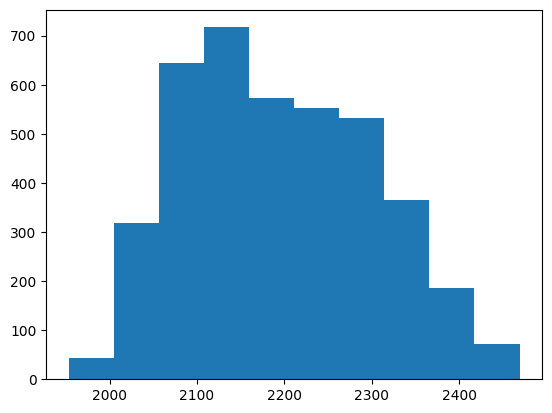

In [131]:
plt.hist(mcmc.get_samples()['total']);

If we didn't know about the previous weights, we'd have to go with a simpler model.

In [133]:
def bears_simple(obs=None):
    mean_weight = numpyro.sample("mean_weight", dist.HalfNormal(50))
    with numpyro.plate("bears", 50):
        y = numpyro.sample('y', dist.Normal(mean_weight, 4),
                                       obs_mask=~jnp.isnan(obs), obs=obs)
    numpyro.deterministic("total", jnp.sum(y))

In [ ]:
mcmc = fit_nuts(bears_simple, obs=obs)

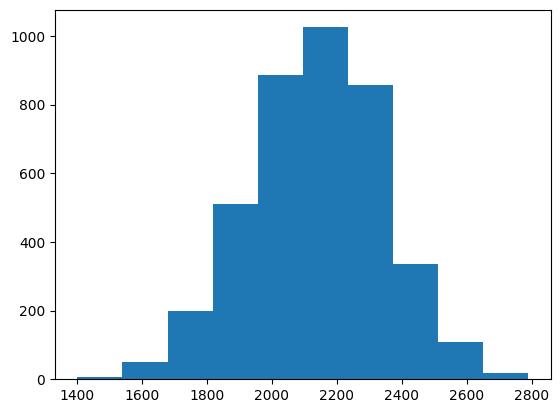

In [135]:
plt.hist(mcmc.get_samples()['total']);

As we can see, the additional information (last year's weights) lets us eliminate a substantial amount of uncertainty!